<a href="https://colab.research.google.com/github/jaekyoungkim/tensor2ml_NLP/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%99%80_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C_%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94_%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC(ch7_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch7

# 버트를 활용한 한국어 기계독해모델 

In [ ]:
#  기계 독해 (machine reading comprehension, mrc)
# 스스로 문서를 분석하고 질문에 대한 최상의 답을 찾아내는 것
# LG-CNS제공한 KorQuAD 1.0활용
# 언어모델은 버트를 활용


In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=ff87954c844f92c6521654b2b76500b037441117ac4c1d6d22d4baddf495b71f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 299 kB/s 
     |████████████████████████████████| 448 kB 94.2 MB/s 


In [4]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 6.8 MB 57.8 MB/s 
     |████████████████████████████████| 596 kB 72.2 MB/s 
     |████████████████████████████████| 895 kB 74.5 MB/s 
     |████████████████████████████████| 67 kB 8.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!git clone https://github.com/NLP-kr/tensorflow-ml-nlp-tf2.git

Cloning into 'tensorflow-ml-nlp-tf2'...
remote: Enumerating objects: 1725, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1725 (delta 48), reused 17 (delta 7), pack-reused 1631
Receiving objects: 100% (1725/1725), 201.21 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (1038/1038), done.
Checking out files: 100% (88/88), done.


In [6]:
# 데이터 분석
import os
import pprint
import re

from konlpy.tag import Okt
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt 
import json
from wordcloud import WordCloud
from random import sample, seed 
from transformers import BertTokenizer
from nltk.tokenize import sent_tokenize
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import sent_tokenize

seed(1234)
phoneme_tokenizer = Okt()


DATA_IN_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_in/KOR'
save_path = '/content/bert_ckpt'

if not os.path.exists(save_path):
  os.makedirs(save_path)

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_tokenizer.save_pretrained(save_path) 
tokenizer = BertWordPieceTokenizer("/content/bert_ckpt/vocab.txt", lowercase=True)

#BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False).save_pretrained(save_path)
#bert_tokenizer = BertWordPieceTokenizer("/content/bert_ckpt/vocab.txt", lowercase=False)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [7]:
train_data_url = 'https://korquad.github.io/dataset/KorQuAD_v1.0_train.json'
train_path = keras.utils.get_file("train.json",train_data_url)
train_data = json.load(open(train_path))

38543360/38527475 [==============================] - 0s 0us/step


In [7]:
# train_data

In [8]:
pprint.pprint(train_data['data'][0])  # pprint 함수를 print보다 좀더 쉽게 데이터를 볼 수 있음

{'paragraphs': [{'context': '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 '
                            '하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 '
                            '산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 '
                            '심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 '
                            '베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 '
                            '서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. '
                            '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 '
                            '반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 '
                            '교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 '
                            '중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 '
                            '연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 '
                            '지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. '
                            '그 사이에 그는 리엔치와 방황하는 네덜란

In [9]:
# 해당 데이터는 json형식으로 구성, 
# data 에 저장된 배열 데이터의 각 원소는  title, paragraphs라는 키로 구성 / paragraphs는  context와 qas로 구성, qas는 answers, id, question으로 구성됨

In [8]:
documents =[]
for d in train_data['data']:
  documents += [p['context'] for p in d['paragraphs']]
print('전체 텍스트수: {}'.format(len(documents)))

전체 텍스트수: 9681


In [ ]:
documents

['1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다. 이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다. 1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다. 이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하여 그 사실을 바그너에게 알렸고, 바그너는 다시 개정된 총보를 리스트에게

In [9]:
# 지문 텍스트 길이분석
len_docs = []
for d in documents:
  len_docs.append(len(d.split()))

In [ ]:
print(len_docs)

[159, 116, 95, 93, 103, 114, 110, 102, 97, 102, 89, 145, 156, 86, 103, 165, 162, 78, 94, 96, 83, 91, 96, 115, 91, 97, 88, 108, 101, 111, 111, 100, 100, 83, 76, 85, 95, 69, 120, 78, 82, 114, 97, 111, 200, 86, 69, 73, 117, 90, 87, 78, 96, 77, 96, 138, 118, 120, 108, 115, 88, 73, 134, 122, 83, 100, 120, 186, 173, 161, 97, 97, 93, 73, 83, 92, 74, 76, 110, 114, 130, 71, 94, 117, 151, 193, 129, 83, 84, 90, 180, 136, 91, 104, 107, 87, 87, 118, 122, 103, 132, 120, 163, 130, 87, 79, 151, 114, 112, 120, 68, 108, 80, 104, 83, 88, 96, 143, 87, 84, 241, 81, 192, 313, 65, 64, 118, 66, 224, 236, 80, 80, 154, 71, 126, 368, 65, 88, 157, 266, 163, 163, 182, 69, 130, 100, 172, 116, 91, 113, 112, 155, 120, 102, 116, 224, 122, 128, 88, 119, 70, 103, 89, 117, 83, 106, 89, 103, 173, 106, 99, 228, 119, 139, 119, 159, 72, 108, 101, 98, 167, 106, 83, 140, 127, 93, 106, 105, 86, 81, 104, 100, 116, 117, 157, 84, 105, 136, 109, 85, 100, 170, 191, 113, 108, 84, 85, 161, 91, 202, 112, 85, 97, 95, 141, 121, 151, 99, 

In [ ]:
print('텍스트 최대길이: {}'.format(np.max(len_docs)))
print('텍스트 평균길이: {:.2f}'.format(np.mean(len_docs)))

텍스트 최대길이: 2244
텍스트 평균길이: 114.87


{'boxes': [<matplotlib.lines.Line2D at 0x7f77ca66df10>],
 'caps': [<matplotlib.lines.Line2D at 0x7f77caabe890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f77d0735a50>],
 'means': [<matplotlib.lines.Line2D at 0x7f77d0735510>],
 'medians': [<matplotlib.lines.Line2D at 0x7f77d07350d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f77ca66d050>,
  <matplotlib.lines.Line2D at 0x7f77ca99be50>]}

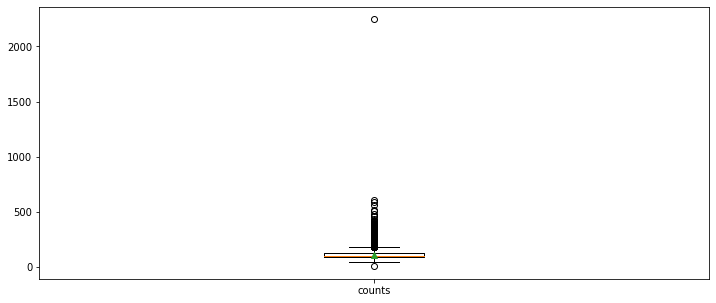

In [ ]:
plt.figure(figsize=(12,5))
plt.boxplot([len_docs], labels=['counts'], showmeans= True)

{'boxes': [<matplotlib.lines.Line2D at 0x7f1cf9227810>],
 'caps': [<matplotlib.lines.Line2D at 0x7f1cf9233550>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1cf923cb10>],
 'means': [<matplotlib.lines.Line2D at 0x7f1cfe5dac90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f1cf923c0d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1cf9227b90>,
  <matplotlib.lines.Line2D at 0x7f1cf9227a50>]}

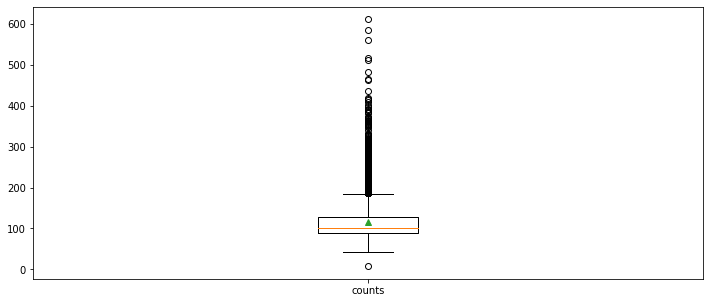

In [ ]:
# 2000이상의 이상치는 삭제하고 다시 그림
filtered_len_docs = [l for l in len_docs if l < 2000]
plt.figure(figsize = (12,5))
plt.boxplot(filtered_len_docs, labels=['counts'], showmeans=True)

In [10]:
# 버트 토크나이저로 토큰 처리를 한 지문 텍스트의 길이

len_bert_tokenized_docs = []
for d in documents:
    len_bert_tokenized_docs.append(len(bert_tokenizer.encode(d, add_special_tokens=False)))

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print(len_bert_tokenized_docs)

[404, 300, 270, 254, 251, 287, 277, 247, 238, 315, 213, 358, 408, 216, 275, 451, 422, 212, 213, 228, 234, 217, 260, 331, 277, 286, 253, 320, 306, 292, 306, 263, 339, 215, 236, 246, 260, 252, 379, 254, 309, 392, 255, 334, 574, 233, 240, 217, 318, 217, 231, 194, 346, 216, 221, 370, 270, 301, 313, 320, 248, 239, 438, 400, 296, 269, 362, 517, 428, 376, 211, 245, 297, 189, 238, 248, 198, 213, 309, 293, 395, 262, 224, 299, 423, 552, 339, 237, 228, 260, 497, 314, 247, 278, 278, 212, 200, 292, 352, 267, 371, 306, 451, 389, 247, 197, 393, 301, 319, 366, 231, 279, 206, 285, 196, 214, 259, 389, 229, 235, 695, 273, 655, 976, 200, 271, 378, 250, 745, 764, 267, 239, 483, 227, 367, 1157, 236, 316, 479, 817, 410, 410, 579, 166, 321, 248, 479, 314, 260, 285, 304, 459, 316, 275, 303, 582, 334, 325, 251, 299, 198, 258, 211, 293, 210, 277, 223, 257, 432, 263, 226, 546, 303, 386, 324, 437, 220, 292, 234, 250, 420, 253, 217, 375, 353, 226, 284, 304, 247, 221, 268, 270, 306, 275, 403, 221, 282, 337, 270, 236

In [ ]:
len(len_bert_tokenized_docs) # 총 9681개의 문서들에 대해서 각각의 token길이를 보여줌

9681

In [ ]:
# 책에 있는 값과 약간 차이남
print("텍스트 최대길이 : {}".format(np.max(len_bert_tokenized_docs)))
print("텍스트 평균길이 : {}".format(np.mean(len_bert_tokenized_docs)))

텍스트 최대길이 : 6367
텍스트 평균길이 : 311.87821506042764


In [11]:
!pip install nltk
import nltk
nltk.download('punkt') #  punkt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
# 워드 클라우드 만들기
sentences =[]
for d in documents :
  sentences += sent_tokenize(d)

In [ ]:
sentences

['1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다.',
 '이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다.',
 '또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다.',
 '여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다.',
 '그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다.',
 '또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다.',
 '결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다.',
 '그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '한편 1840년부터 바그너와 알고 지내던 리스트가 잊혀져 있던 1악장을 부활시켜 1852년에 바이마르에서 연주했다.',
 '이것을 계기로 바그너도 이 작품에 다시 관심을 갖게 되었고, 그 해 9월에는 총보의 반환을 요구하여 이를 서곡으로 간추린 다음 수정을 했고 브라이트코프흐 & 헤르텔 출판사에서 출판할 개정판도 준비했다.',
 '1853년 5월에는 리스트가 이 작품이 수정되었다는 것을 인정했지만, 끝내 바그너의 출판 계획은 무산되고 말았다.',
 '이후 1855년에 리스트가 자신의 작품 파우스트 교향곡을 거의 완성하

In [13]:
print('전체 문장수 {}'.format(len(sentences)))
sampled_docs = sample(sentences, 20000) # 1/3 크기임

전체 문장수 67892


(-0.5, 799.5, 599.5, -0.5)

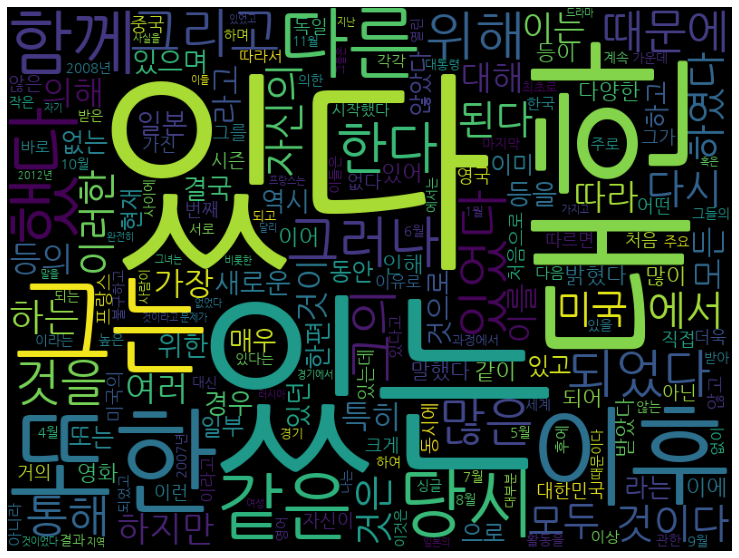

In [ ]:
font_path = os.path.join(DATA_IN_PATH, 'NanumGothic.ttf')
cloud = WordCloud(font_path = font_path, width=800, height=600).generate(' '.join(sampled_docs))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [13]:
# 지식 데이터를 기반으로 하다보니 이 같은 띄어쓰기 토큰이 많이 나오는것을 확인 할 수 있다.
# 결국, 때문에, 또한 과 같은 인과와 나열에 대한 토큰 정보도 상당수 존재함
# 명사로 분석하면 좀더 명확하게 지식 데이터에 어떤 정보가 있는지 알 수 있을것
noun_extracted_docs = list()
for d in sampled_docs:
  noun_extracted_docs += phoneme_tokenizer.nouns(d)  # phoneme_tokenizer.nouns 함수를 사용해서 형태소 분석으로 구한 명사에 대한 어휘분석

(-0.5, 799.5, 599.5, -0.5)

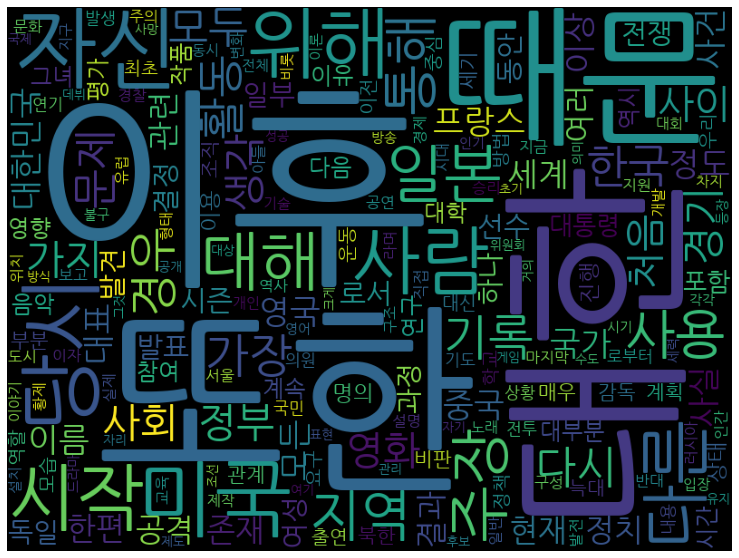

In [ ]:
cloud = WordCloud(font_path = font_path, width = 800, height = 600).generate(' '.join(noun_extracted_docs))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
# 때문, 이후 이외에는 미국 한국 정부 정치 전쟁 문화사람 이름과 같은 큰 주제 또는 주제에 속하는 명사 단어가 많이 보임

In [14]:
questions =[]
for d in train_data['data']:
  qas = [p['qas'] for p in d['paragraphs']]  # paragraphs에서 qas 를 가져옴
  for c in qas : #qas에서 가져온 질문들을 하나씩 넣음
    questions += [q['question'] for q in c]


In [ ]:
print('전체 질문수 :{}'.format(len(questions)))  # 60407

전체 질문수 :60407


In [15]:
len_qs = []
for q in questions:
  len_qs.append(len(q.split()))

In [ ]:
print(len_qs)

[7, 7, 9, 7, 8, 5, 6, 5, 8, 8, 7, 4, 6, 4, 6, 5, 4, 7, 5, 5, 4, 3, 4, 5, 8, 6, 7, 6, 10, 12, 17, 8, 14, 14, 13, 17, 7, 15, 15, 17, 9, 13, 7, 9, 6, 4, 3, 7, 4, 13, 13, 16, 7, 9, 7, 7, 9, 15, 9, 8, 7, 10, 5, 12, 6, 13, 12, 6, 5, 9, 6, 8, 10, 4, 5, 6, 8, 7, 7, 13, 8, 4, 5, 8, 9, 6, 6, 6, 4, 4, 5, 3, 7, 7, 6, 7, 11, 4, 7, 8, 11, 13, 12, 10, 10, 5, 5, 12, 5, 5, 6, 9, 9, 6, 8, 7, 5, 13, 14, 6, 6, 3, 4, 7, 12, 9, 5, 7, 8, 11, 8, 13, 4, 10, 8, 12, 10, 7, 12, 10, 7, 7, 7, 13, 14, 10, 9, 7, 5, 12, 4, 4, 5, 7, 7, 3, 4, 9, 3, 12, 4, 6, 4, 12, 11, 7, 7, 6, 2, 5, 5, 3, 11, 6, 10, 9, 10, 4, 5, 2, 9, 6, 9, 9, 6, 7, 7, 3, 6, 7, 6, 13, 6, 7, 12, 11, 7, 8, 11, 13, 5, 6, 5, 4, 7, 11, 11, 9, 7, 12, 6, 6, 5, 5, 7, 6, 9, 5, 5, 8, 12, 7, 7, 14, 11, 10, 6, 10, 12, 10, 4, 9, 14, 17, 16, 4, 5, 14, 7, 12, 4, 9, 13, 12, 5, 5, 3, 6, 6, 6, 8, 10, 3, 6, 3, 3, 9, 11, 7, 6, 2, 6, 5, 5, 9, 7, 14, 5, 6, 10, 2, 15, 10, 4, 6, 7, 4, 9, 6, 5, 10, 5, 7, 6, 5, 5, 5, 5, 5, 8, 9, 7, 5, 11, 12, 11, 10, 5, 12, 6, 6, 8, 9, 12, 13, 

In [ ]:
print('질문의 최대 길이 :{}'.format(np.max(len_qs)))
print('질문의 평균 길이 :{:.2f}'.format(np.mean(len_qs)))


질문의 최대 길이 :35
질문의 평균 길이 :7.85


In [16]:
len_bert_tokenized_q = []
for q in questions:
  len_bert_tokenized_q.append(len(bert_tokenizer.encode(q, add_special_tokens=False)))

In [ ]:
# 책과 숫자가 다름
print('텍스트 최대 길이 {}'.format(np.max(len_bert_tokenized_q)))
print('텍스트 평균 길이 {}'.format(np.mean(len_bert_tokenized_q)))


텍스트 최대 길이 91
텍스트 평균 길이 22.068055026735312


In [17]:
sampled_questions = sample(questions, 20000)

(-0.5, 799.5, 599.5, -0.5)

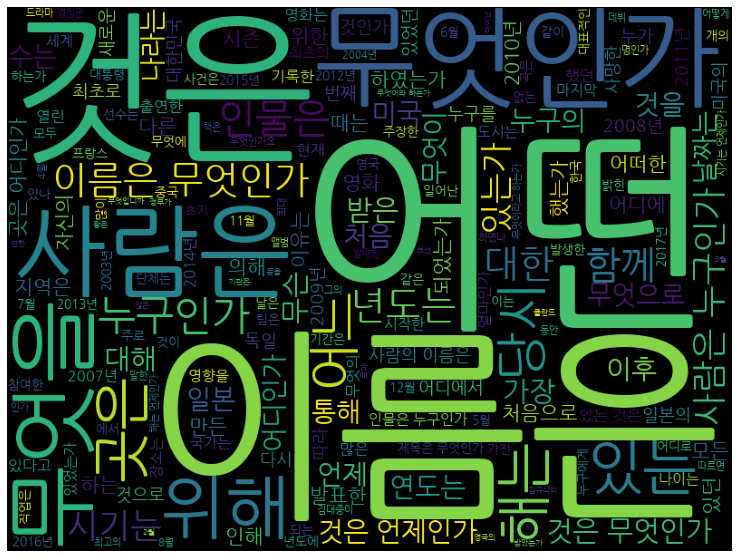

In [ ]:
cloud = WordCloud(font_path = font_path, width = 800, height = 600).generate(' '.join(sampled_questions))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
# 장소, 시간 사물에 대한 질문이 많은것을 볼 수 있음

(-0.5, 799.5, 599.5, -0.5)

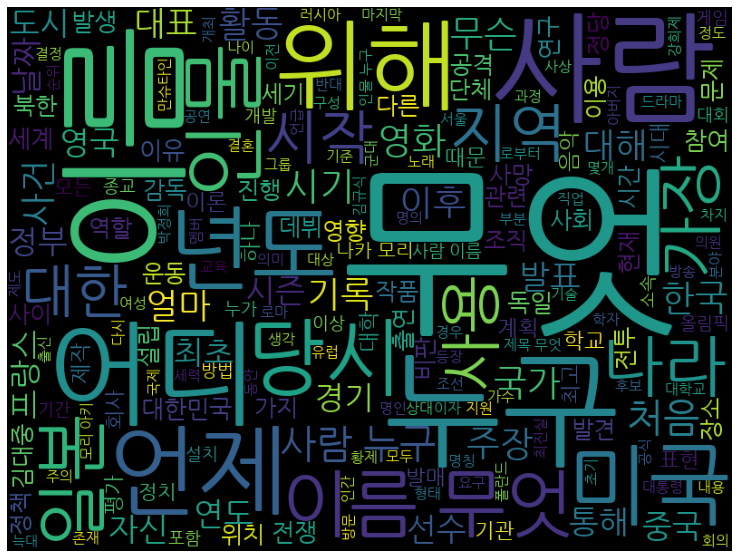

In [ ]:
# 명사빈도 분석을 통해 좀더 자세하게 알아보기
noun_extracted_qs = list()
for q in sampled_questions:
  noun_extracted_qs +=phoneme_tokenizer.nouns(q)

cloud = WordCloud(font_path = font_path, width = 800, height = 600).generate(' '.join(noun_extracted_qs))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')
# 장소, 시간 사물에 대한 질문이 많은것을 볼 수 있음

In [14]:
# 모듈 불러오기
# 입력 : [CLS] 질문 [SEP] 본문 [SEP]
import os
import random
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tokenizers import BertWordPieceTokenizer 
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import urllib 

import wget
import matplotlib.pyplot as plt 


In [15]:
MAX_LEN = 384 # 최대 시퀀스길이는 EDA를 통해 구한것 ,  본문 350 + 질문 34로 잡은듯
EPOCHS =3 
VERBOSE =2 
BATCH_SIZE =16 


In [16]:
DATA_OUT_PATH = '/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR'

In [17]:
# 시각화 함수 만들기
def plot_graphs(history, string, string_1, string_2): #  전체 손실값, 시작점 손실값, 끝점 손실값 / 에폭당 손실값을 시각화하는 함수임
  plt.plot(history.history[string])
  plt.plot(history.history[string_1])
  plt.plot(history.history[string_2])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, string_1, string_2])
  plt.show()

In [18]:
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "/content/bert-base-multilingual-cased/"
if not os.path.exists(save_path):
  os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)  # slow_tokenizer 

tokenizer = BertWordPieceTokenizer("/content/bert-base-multilingual-cased/vocab.txt", lowercase=False)
# 이전의 방법과 다른점은 버트 토크나이저를 불러와서 저장하고, 저장된 토크나이저를 활용해 데이터 전처리와 입력 데이터에 사용함


In [19]:
# 전처리에 앞서 훈련과 평가를 위한 데이터셋 다운로드
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file("train.json", train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)
train_data = json.load(open(train_path))
dev_data = json.load(open(eval_path))

3891200/3881058 [==============================] - 0s 0us/step


In [20]:
# bert 모델과 환경파일 불러오기
# 기존 모델들은  허깅페이스에서 지원하는 고수준api를 통해 데이터 처리 및 모델 학습이 가능했으나 한국어 기계독해는 모델과 토크나이저 원형정보를 저장하고 저장된 정보를 가지고 저수준api를 만들어 사용
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out = '/content/bert-base-multilingual-cased/')

'/content/bert-base-multilingual-cased//bert-base-multilingual-cased-config.json'

In [21]:
# os.rename()을 사용하여 파일 이름을 변경
os.rename('/content/bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', '/content/bert-base-multilingual-cased/config.json')

In [22]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5', out = '/content/bert-base-multilingual-cased/')

'/content/bert-base-multilingual-cased//bert-base-multilingual-cased-tf_model.h5'

In [23]:
os.rename('/content/bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', '/content/bert-base-multilingual-cased/tf_model.h5')

In [24]:
# create squad_examples 함수 생성
def create_squad_examples(raw_data):
  squad_examples = []
  for item in raw_data['data']: 
    for para in item['paragraphs']: 
      context = para['context']   # 본문 
      for qa in para['qas']:
        question = qa['question'] # 질문
        answer_text =  qa['answers'][0]['text'] # 질문에 대한 정답
        start_char_idx = qa['answers'][0]['answer_start']  # 본문에서 정답의 위치
        squad_eg = SquadExample(question, context,start_char_idx, answer_text)
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
  return squad_examples

# 질문 : 철수는 어디에 갔는가?
# 본문 : 철수는 오늘 집에서 나와서 학교에 갔다
# 정답 : 학교
# 위치 : 16

In [25]:
# SquadExample을 통해서 모델에 입력가능한 학습 데이터로 변경하게됨 
# 결괏값은 정제되지 않은 데이터를 학습할때 모델에 입력할 수 있게 해주는 클래스
# __init__ 이 호출되고  squad_eg 에 할당됨 
class SquadExample: 

  def __init__(self, question, context, start_char_idx, answer_text):   # 1차 가공한 값들이 들어옴  새롭게 등장한 변수가 있음(self.skip: 데이터를 사용할지 안할지를 결정하는 변수)
    self.question = question
    self.context = context
    self.start_char_idx = start_char_idx
    self.answer_text = answer_text
    self.skip = False

  def preprocess(self):
    context = self.context 
    question = self.question 
    answer_text = self.answer_text 
    start_char_idx = self.start_char_idx 

    # 스페이스 단위로 나누기 -> 나눈값들을 스페이스 단위로 바꿔서 해당 입력에 문제가 일어날 요소를 사전에 정리하
    context = " ".join(str(context).split())
    question = " ".join(str(question).split())
    answer = " ".join(str(answer_text).split())

    end_char_idx = start_char_idx + len(answer)
    
    if end_char_idx >= len(context):  # end_char_idx가  문장의 길이를 넘어가고 있음
      self.skip = True # 답이 본문범위에 존재하지않는다는 것을 의미함 -> 예외처리를 하기위해 설정함
      return 
    
    # tokenizer.encoder 함수를 통해 토큰화되고 인덱스로 변경되면서 시작 토큰의 위치와 끝 토큰을 다시 계산하는 코드

    is_char_in_ans = [0] * len(context)  # context 길이만큼 is_char_in_ans 의 값을 모두 0으로 만들기 
    for idx in range(start_char_idx, end_char_idx): # 답이 존재하는 부분을 인덱스에 1로 채우는 과정
      is_char_in_ans[idx] = 1
    
    tokenized_context = tokenizer.encode(context) # 본문 -> 사전의 인덱스 값으로 변환한 값인 tokenized_context를 만들기
    ans_token_idx = []
    # offsets  함수 : 시작위치로부터 각 음절의 위치를 표현한값
    # 나는 학교에 간다 ->(encode) 나는, 학, ##교, ##에, 간, ##다
    # offsets를 사용하는 이유 :  json 에서 받은 데이터에서 본문에서 값이 어디에 위치하는지  start_char_idx, end_char_idx 를 구했다. 그러나 encode 에 넣으면 토크나이저에 의해 각 띄어쓰기된 토큰정보가 분리
    # 시작과 끝에 대한 인덱스 값이 변함 

    for idx ,(start, end) in enumerate(tokenized_context.offsets):
      if sum(is_char_in_ans[start:end]) > 0 :
        ans_token_idx.append(idx)
    
    if len(ans_token_idx) == 0 :  # 답이 존재하지 않는것임
      self.skip = True
      return
    
    start_token_idx = ans_token_idx[0] # 정답이 시작하는 토큰의 인덱스
    end_token_idx = ans_token_idx[-1] # 정답이 끝나는 인덱스

    # 본문과 질문을 연결하는 부분 
    tokenized_question = tokenizer.encode(question)
    input_ids = tokenized_context.ids + tokenized_question.ids[1:] # 질문을 인덱스화해서 본문뒤에 붙여 input_ids 를 만들기

    #  버트의 입력형태인 토큰타입으로 만드는데 문맥은 0으로 질문으로 만들고 어텐션 마스크 범위를 설정함
    token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
    attention_mask = [1] * len(input_ids) 
    padding_length = MAX_LEN - len(input_ids)
    # 최대 길이만큼 패드 설정을 하고, 예외처리로 전체 길이가 0 이하이면 self.skip에 true를 지정해 해당 데이터를 사용 안함

    if padding_length > 0 : # padding을 하는경우 
      input_ids = input_ids + ([0] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length) 
      token_type_ids = token_type_ids + ([0] * padding_length)

    elif padding_length < 0 : # skip
      self.skip =True 
      
      return
    self.input_ids = input_ids
    self.token_type_ids = token_type_ids
    self.attention_mask = attention_mask
    self.start_token_idx = start_token_idx
    self.end_token_idx = end_token_idx
    self.context_token_to_char  = tokenized_context.offsets


  


In [26]:
def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [27]:
train_path

'/root/.keras/datasets/train.json'

In [28]:
eval_path

'/root/.keras/datasets/eval.json'

In [29]:
## 모델에 들어갈 훈련과 평가를 위한 입력 형태로 데이터를 변경하기
with open(train_path) as f :
  raw_train_data = json.load(f) 


train_squad_examples = create_squad_examples(raw_train_data)  # create_squad_examples 함수에 json파일을 넣어서  train_squad_examples 를 만듦
# create_squad_examples 함수는  json 데이터 구조에서 모델 입력에 필요한 질문 본문 정답을 가져오는 함수
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created")


60407 training points created


In [30]:
with open(eval_path) as f:
  raw_eval_data = json.load(f)

eval_squad_examples = create_squad_examples(raw_eval_data)  # create_squad_examples 함수에 json파일을 넣어서  train_squad_examples 를 만듦
# create_squad_examples 함수는  json 데이터 구조에서 모델 입력에 필요한 질문 본문 정답을 가져오는 함수
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} eval points created")


5774 eval points created


In [31]:
# 491 page 
# KorQuAD v1.0 학습 및 테스트
# 모델 클래스를 통해 버트 모델을 활용한 한국어 기계독해 모델정의
class TFBErtQuestionAnswering(tf.keras.Model):  # tf.keras.Model을 상속받음 , __init__ 과 call두개의 함수를 선언함
  def __init__(self, model_name, dir_path, num_class) : # 인자로 model_name, dir_path, num_class 를 받음
    super(TFBErtQuestionAnswering, self).__init__()
    self.encoder =TFBertModel.from_pretrained(model_name, cache_dir =dir_path)  #  저장해둔 모델을 불러옴
    
    # start_logit , end_logit 을 맞출수 있도록 두개의 dense층을 선언
    # 기계독해는 정답이 되는 토큰의 시작위치와 끝 위치를 맞춰야함
    self.start_logit = tf.keras.layers.Dense(num_class, name = 'start_logit', use_bias = False)
    self.end_logit = tf.keras.layers.Dense(num_class, name = 'end_logit', use_bias = False)

    # 로지값을 평평하게 펴주는 역할로서 1차원으로 변환시켜줌
    self.flatten = tf.keras.layers.Flatten()
    self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax) # softmax 를 적용
  
  def call(self, inputs): # inputs 을 받아 들임 self.encoder에 들어갈 형태 / 두 함수가 어떻게 활용되는지 보여줌

    input_ids,  token_type_ids, attention_mask = inputs  # 버트모델에 들어갈 입력 인덱스값, token_type_ids인 세그먼트 임베딩값, pad 값이 들어잇는 attention_mask 가 담겨있음
    embedding = self.encoder(input_ids, token_type_ids = token_type_ids, attention_mask = attention_mask)[0]
    
    start_logits = self.start_logit(embedding)
    start_logits = self.flatten(start_logits)
    
    end_logits = self.end_logit(embedding)
    end_logits = self.flatten(end_logits)

    start_probs = self.softmax(start_logits)
    end_probs = self.softmax(end_logits)

    return start_probs, end_probs


In [32]:
korquad_model = TFBErtQuestionAnswering(model_name = '/content/bert-base-multilingual-cased/', dir_path = 'bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5)  # 논문에서 언급한 학습률
loss = keras.losses.SparseCategoricalCrossentropy(from_logits= False) # 소프트맥스를 통과한 확률값을 활용하기 때문에  from_logits 는  false로 설정함

Some layers from the model checkpoint at /content/bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
#  한국어 이외 다른 특수기호가 포함될 수 있음 특수기호들은 평가에 있어 평가점수에 영향을 줄 수 있는 요인이기 때문에 삭제

def normalized_answer(s):    
    def remove_(text):
        ''' 불필요한 기호 제거 '''
        text = re.sub("'", " ", text)
        text = re.sub('"', " ", text)
        text = re.sub('《', " ", text)
        text = re.sub('》', " ", text)
        text = re.sub('<', " ", text)
        text = re.sub('>', " ", text) 
        text = re.sub('〈', " ", text)
        text = re.sub('〉', " ", text)   
        text = re.sub("\(", " ", text)
        text = re.sub("\)", " ", text)
        text = re.sub("‘", " ", text)
        text = re.sub("’", " ", text)      
        return text

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_punc(lower(remove_(s))))

In [34]:
# exact matching(정확매칭)
class ExactMatch(keras.callbacks.Callback): 
  def __init__(self, x_eval, y_eval): # 평가에 사용될 평가 데이터를 받음,  x_eval : 본문과 질문이 결합된 데이터 , y_eval : 정답
    self.x_eval = x_eval
    self.y_eval = y_eval
  
  def on_epoch_end(self, epoch, logs=None): # 예측값과 정답을 비교하는 함수, 인자로는  epoch값을 받음

    pred_start, pred_end = self.model.predict(self.x_eval)  # 시작값과 끝점값을 얻게됨 
    count = 0 
    eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]  # skip==false  , 정답이 본문에 포함돼 있음을 의미함
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
      squad_eg = eval_examples_no_skip[idx]  # 본문에 정답이 존재하는 값들이 모인 eval_examples_no_skip엣 하나씩 값을 불러옴
      offsets = squad_eg.context_token_to_char # 정답이 시작되는 본문의 위치정보 해당값을  offsets에 넣음
      start = np.argmax(start)  # softmax를 통해 확률값중 가장 높은 토큰의 확률값을 가져와 정답시작점 찾음
      end = np.argmax(end)
      if start >= len(offsets):  
        continue
      pred_char_start = offsets[start][0]

      if end < len(offsets):
        pred_char_end = offsets[end][1]
        pred_ans = squad_eg.context[pred_char_start : pred_char_end]

      else :
        pred_ans = squad_eg.context[pred_char_start:]  # 시작점의 토큰위치와 정답 끝점의 토큰위치가 답변을 찾는 본문의 오프셋을 넘는경우 예외처리 수행
      
      normalized_pred_ans = normalized_answer(pred_ans)
      normalized_true_ans = normalized_answer(squad_eg.answer_text)
      if normalized_pred_ans in normalized_true_ans:
        count += 1
    acc = count / len(self.y_eval[0])
    print(f"\nepoch={epoch+1}, exact match score = {acc:.2f}")

In [35]:
exact_match_callback = ExactMatch(x_eval, y_eval)
korquad_model.compile(optimizer = optimizer , loss = [loss, loss])


In [36]:
model_name = 'tf2_bert_korquad'
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

/content/tensorflow-ml-nlp-tf2/7.PRETRAIN_METHOD/data_out/KOR/tf2_bert_korquad -- Folder create complete 



In [37]:
y_train # 시작점과 끝지점을 보여주고있음

[array([238,  13, 204, ...,  64, 220,   6]),
 array([241,  14, 207, ...,  65, 222,  12])]

In [38]:
history = korquad_model.fit(x_train, y_train, epochs= 3, verbose =VERBOSE, batch_size = BATCH_SIZE, callbacks =[exact_match_callback, cp_callback])

Epoch 1/3

epoch=1, exact match score = 0.74
2941/2941 - 2419s - loss: 1.6001 - output_1_loss: 0.7345 - output_2_loss: 0.8656 - 2419s/epoch - 822ms/step
Epoch 2/3

epoch=2, exact match score = 0.73
2941/2941 - 2371s - loss: 1.0589 - output_1_loss: 0.4792 - output_2_loss: 0.5796 - 2371s/epoch - 806ms/step
Epoch 3/3

epoch=3, exact match score = 0.73
2941/2941 - 2369s - loss: 0.8099 - output_1_loss: 0.3596 - output_2_loss: 0.4502 - 2369s/epoch - 806ms/step


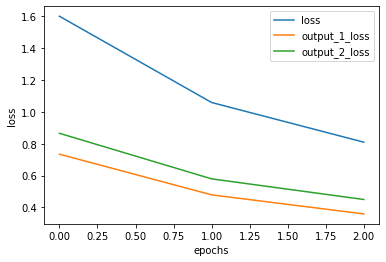

In [39]:
plot_graphs(history,'loss', 'output_1_loss', 'output_2_loss')

In [ ]:
history

# 